# Статистика, DS-поток
## Задание S.11

Задача 1: Реализация стат. свойств в линейной регрессии.
▫️ Наличие решения. (50.0)
▫️ Не было работы с категориальнами признаками. Комм. Линейная регрессия строит линейную зависимость, а на категориальных признаках даже нет отношения порядка. Стоило воспользоваться One-Hot Encoding'ом. (-10.0)
▫️ Нет работы с выбросами. (-2.0)
Баллы: 38.0 / 50.0

Задача 2: Исследование t-test для гомо- и гетероскедастичности.
▫️ Пункт 1: наличие решения. (35.0)
▫️ Пункт 2: наличие решения. (25.0)
▫️ Пункт 3: наличие решения. (25.0)
▫️ Пункт 4: наличие решения. (15.0)
▫️ Инд. комм. Хотелось бы посмотреть в 4 пункте ещё мощность при отрицательных тета (-5.0)
Баллы: 95.0 / 100.0

Сумма: 133 / 150.0

In [39]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

from zipfile import ZipFile
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

---
### Задача P1.

Напишите класс, реализующий линейную регрессию и ее статистические свойства в условиях гомоскедастичности.

In [40]:
class LinearRegression:
    '''
    Класс, реализующий линейную регрессию c помощью МНК.
    '''

    def __init__(self, fit_intercept=True, alpha=0.05):
        '''
        :param fit_intercept: добавлять ли смещение(константный признак)
        :param alpha: уровень значимости критерия,
                      (1-alpha): уровень доверия дов. интервала
        '''
        self.fit_intercept = fit_intercept
        self.alpha = alpha

    def fit(self, X, Y):
        '''
        Функция обучения модели.

        Предполагается модель Y = X * theta + epsilon,
        где epsilon имеет норм. распр. с параметрами (0, sigma^2 * I_n).

        :param X: регрессор (матрица размера n x d),
        :param Y: отклик (матрица размера n x 1),
        '''

        self.n, self.d = X.shape
        # При необходимости добавьте константу, используйте self.fit_intercept
        if self.fit_intercept:
            X = np.concatenate([X, np.ones(self.n)[:, None]], axis=1)
            self.d += 1

        self.theta = np.linalg.inv(X.T @ X) @ X.T @ Y
        RSS = ((Y - X @ self.theta) ** 2).sum()
        self.sigma_sq = RSS / (self.n - self.d)
        self.conf_int = np.stack([self.theta-np.sqrt(self.sigma_sq * np.diag(np.linalg.inv(X.T @ X))) * sps.t(df=self.n-self.d).ppf(1-self.alpha/2), \
                                  self.theta+np.sqrt(self.sigma_sq * np.diag(np.linalg.inv(X.T @ X))) * sps.t(df=self.n-self.d).ppf(1-self.alpha/2)])
        self.t_stats = self.theta / np.sqrt(self.sigma_sq * np.diag(np.linalg.inv(X.T @ X)))
        self.t_pvalue = sps.t(df=self.n-self.d).sf(np.abs(self.t_stats)) * 2

        # <статистики критерия о незначимости регрессии>
        R2 = 1 - RSS / ((Y - Y.mean()) ** 2).sum()
        self.f_stat = R2 / (1 - R2) * (self.n - self.d) / (self.d - 1)

        # <p-value критерия о незначимости регрессии>
        self.f_pvalue = sps.f(self.d-1, self.n - self.d).sf(self.f_stat)
        return self

    def summary(self):
        '''
        Выводит таблицу с информацией для каждого коэффициента,
        в которой указана его оценка, границы дов. интервала,
        статистика критерия и значение p-value
        '''

        print(f'Линейная регрессия на {self.d} признаках и {self.n} объектах')
        print(f'Sigma: {self.sigma_sq:.6f}')

        # Напечатайте результаты F-теста
        print(f'F-statistic: {self.f_stat:.3f}, F-statistic pvalue: {self.f_pvalue:.3f}')


        # Далее напечатайте таблицу,
        # в которой для каждого коэффициента (по строкам)
        # будут следующие столбцы:
        # оценка, границы дов. интервала (два столбца),
        # статистика критерия, p-value
        display(pd.DataFrame({'theta' : pd.Series(self.theta, index=[f'theta_{i}' for i in range(self.d)]),
                              'left_int' : pd.Series(self.conf_int[0], index=[f'theta_{i}' for i in range(self.d)]),
                              'right_int' : pd.Series(self.conf_int[1], index=[f'theta_{i}' for i in range(self.d)]),
                              't_stat' : pd.Series(self.t_stats, index=[f'theta_{i}' for i in range(self.d)]),
                              't_pvalue' : pd.Series(self.t_pvalue, index=[f'theta_{i}' for i in range(self.d)])
                              }))

    def predict(self, X, type_interval=None):
        '''
        Возвращает предсказание отклика на новых объектах X
        и опционально доверительный/предсказательный интервал.

        :param X: матрица объектов размера n x d
        :param type_interval: тип дов. интервала.
            Для этого параметра возможны три варианта:
            * None - возвратить только предсказание,
                    размер return-a: n;
            * 'confidence' - возвратить предсказание и
                доверительный интервал для среднего отклика,
                размер return-a: n x 3;
            * 'prediction' - возвратить предсказание и
                предсказательный интервал для новых объектов,
                размер return-a: n x 3.

        :return y_pred: предсказание/предсказание и дов./предсказ. инт.

        '''

        n, _ = X.shape
        if self.fit_intercept:
            X = np.concatenate([X, np.ones(n)[:, None]], axis=1)

        pred = X @ self.theta

        if not type_interval:
            return pred
        
        elif type_interval == 'confidence':
            left = pred-np.sqrt(np.diag(self.sigma_sq * X @ np.linalg.inv(X.T @ X) @ X.T)) * sps.t(df=self.n-self.d).ppf(1-self.alpha/2)
            right = pred+np.sqrt(np.diag(self.sigma_sq * X @ np.linalg.inv(X.T @ X) @ X.T)) * sps.t(df=self.n-self.d).ppf(1-self.alpha/2)
            return np.stack([pred, left, right])

        else:
            left = pred-np.sqrt(self.sigma_sq + np.diag(self.sigma_sq * X @ np.linalg.inv(X.T @ X) @ X.T)) * sps.t(df=self.n-self.d).ppf(1-self.alpha/2)
            right = pred+np.sqrt(self.sigma_sq + np.diag(self.sigma_sq * X @ np.linalg.inv(X.T @ X) @ X.T)) * sps.t(df=self.n-self.d).ppf(1-self.alpha/2)
            return np.stack([pred, left, right])

Примените написанный класс для данных из задания 6 курса Введение в анализ данных и напечатайте `summary`. Предварительно разделите данные на обучающую и тестовую части, выполните необходимые преобразования признаков.

Проверку применимости критериев в данной задаче выполнять не нужно.

In [41]:
dzip = ZipFile('bike+sharing+dataset (1).zip')
df = pd.read_csv(dzip.open('day.csv'))
df = df[['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', \
         'temp', 'atemp', 'hum', 'windspeed', 'cnt']]
df.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [42]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cnt', axis=1), df['cnt'], test_size=0.2)

In [43]:
X_train.shape

(584, 10)

In [44]:
lin_reg = LinearRegression().fit(X_train, y_train)
lin_reg.summary()

Линейная регрессия на 11 признаках и 584 объектах
Sigma: 1818144.795301
F-statistic: 63.197, F-statistic pvalue: 0.000


,theta,left_int,right_int,t_stat,t_pvalue
theta_0,497.608292,312.222296,682.994288,5.272020,1.914514e-07
theta_1,-24.886649,-83.002891,33.229594,-0.841076,4.006562e-01
theta_2,-727.893470,-1423.823309,-31.963630,-2.054323,4.039746e-02
theta_3,54.202753,-0.695300,109.100805,1.939237,5.296306e-02
theta_4,111.964829,-129.421465,353.351122,0.911036,3.626596e-01
theta_5,-560.291427,-819.509758,-301.073096,-4.245361,2.545780e-05
theta_6,2880.934945,-1570.104771,7331.974662,1.271272,2.041478e-01
theta_7,2934.557615,-2107.854867,7976.970097,1.143064,2.534892e-01
theta_8,-1923.384519,-2965.579720,-881.189318,-3.624795,3.149284e-04
theta_9,-2589.922114,-4136.681168,-1043.163059,-3.288747,1.068053e-03


Отвергаем гипотезу о незначимости регрессии

Для объектов из тестовой части постройте
* точечные предсказания,
* доверительный интервал для среднего таргета,
* предсказательный интервал для таргета.

Посчитайте, насколько часто истинное значение таргета попадает в построенные интервалы. Можно ли как-то проинтерпретировать это число?

In [45]:
pred, conf_left, conf_right = lin_reg.predict(X_test, type_interval='confidence')
pred, pred_left, pred_right = lin_reg.predict(X_test, type_interval='prediction')
conf_coverage = ((y_test >= conf_left) & (y_test <= conf_right)).sum() / y_test.shape[0]
pred_coverage = ((y_test >= pred_left) & (y_test <= pred_right)).sum() / y_test.shape[0]
print(f'Доля покрытия интервала для среднего: {conf_coverage}')
print(f'Доля покрытия интервала для предсказания: {pred_coverage}')

Доля покрытия интервала для среднего: 0.29931972789115646
Доля покрытия интервала для предсказания: 0.9795918367346939


Доля покрытия интервала значительно больше доли покрытия интервала для среднего, доля соответствует уровню доверия 95%. Так этот параметр и можно интерпретировать. 

Доля покрытия интервала для среднего такая низкая, потому что присутствует шум

Выберите один вещественный признак, для которого отвергается гипотеза о незначимости. Постройте еще раз модель, используя только этот признак, а также константный признак. Нарисуйте график, на котором отметьте
* точки выборки,
* точечные предсказания,
* доверительный и предсказательный интервалы.

In [60]:
df_one_train = np.array(X_train['hum']).reshape(-1, 1)
df_one_test = np.array(X_test['hum']).reshape(-1, 1)

# Обучение модели
lin_reg = LinearRegression().fit(df_one_train, y_train)
lin_reg.summary()

Линейная регрессия на 2 признаках и 584 объектах
Sigma: 3738729.538328
F-statistic: 3.976, F-statistic pvalue: 0.047


,theta,left_int,right_int,t_stat,t_pvalue
theta_0,-1121.472160,-2226.068449,-16.875871,-1.994055,4.661219e-02
theta_1,5243.452757,4533.283922,5953.621593,14.501333,6.649633e-41


Отвергнуть гипотезу о незначимости регрессии не можем

In [61]:
pred, conf_left, conf_right = lin_reg.predict(np.sort(np.array(df_one_test)), type_interval='confidence')
pred, pred_left, pred_right = lin_reg.predict(np.sort(np.array(df_one_test)), type_interval='prediction')
conf_coverage = ((y_test >= conf_left) & (y_test <= conf_right)).sum() / y_test.shape[0]
pred_coverage = ((y_test >= pred_left) & (y_test <= pred_right)).sum() / y_test.shape[0]

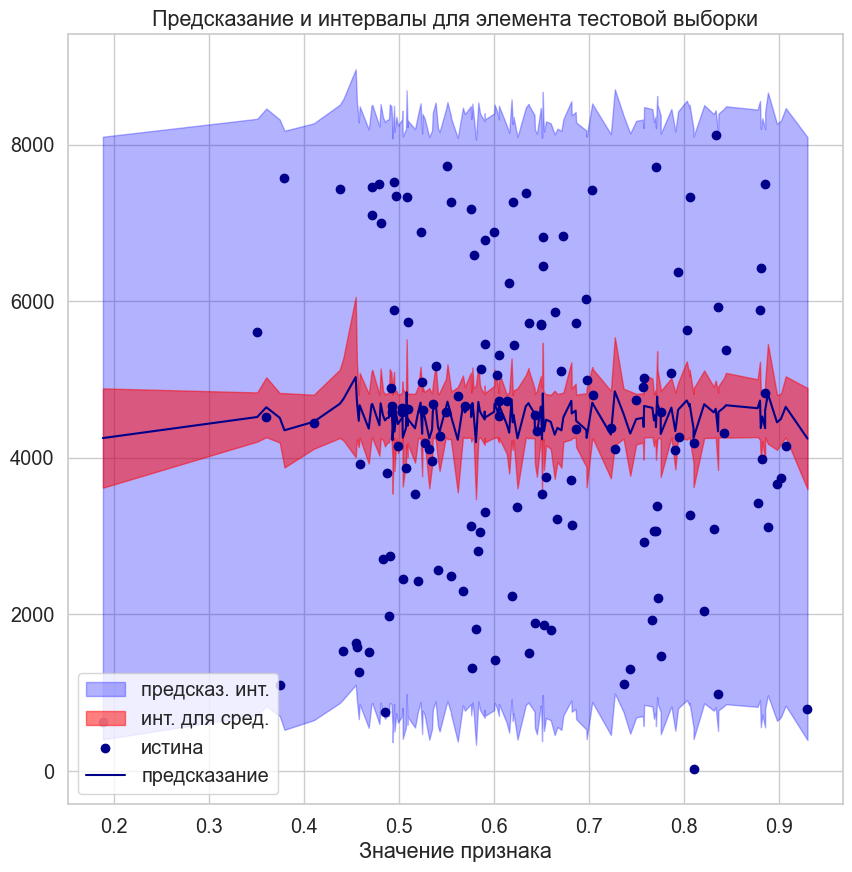

In [65]:
plt.figure(figsize=(10, 10))
plt.fill_between(np.sort(np.array(df_one_test.flatten())), pred_left, pred_right, color='blue', label='предсказ. инт.', alpha=0.3)
plt.fill_between(np.sort(np.array(df_one_test.flatten())), conf_left, conf_right, color='red', label='инт. для сред.', alpha=0.5)
plt.scatter(np.sort(np.array(df_one_test.flatten())), np.array(y_test), color='darkblue', label='истина')
plt.plot(np.sort(np.array(df_one_test.flatten())), pred, color='darkblue', label='предсказание')
plt.title('Предсказание и интервалы для элемента тестовой выборки')
plt.xlabel('Значение признака')
plt.legend()
plt.show()

**Выводы:**

Предсказательный интервал учитывает шум, интервал для среднего - нет. Поэтому предсказательный интервал шире и гораздо чаще покрывает истинное значение $y$ из выборки.

---
### Задача P2.

Рассмотрим два признака $x_1, x_2$ и целевую метку $y$.
Будем предполагать зависимость $y(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2$.
Для проверки гипотезы о *не*значимости признака $x_2$, то есть $\mathsf{H}_0\colon \theta_2=0$, на практике широко используется $T$-критерий (например, в AB-тестировании), который мы получили в предположениях гауссовской линейной модели. Проведем его исследования.

**1.** Оцените вероятность ошибки I рода в предположениях гауссовской линейной модели, в частности, **при наличии гомоскедастичности**. Для этого повторите достаточное количество раз (не менее $10^4$) следующую процедуру и усредните результаты.
1. Сгенерируйте некоторым образом выборку размера 200 из признаков $x_1$ и $x_2$.
2. Сгенерируйте целевую метку в предположениях гауссовской линейной модели. В процедуре оценки вероятности ошибки I рода на данном этапе необходимо брать $\theta_2 = 0$, то есть генерировать данные при справедливости $\mathsf{H}_0$.
3. Примените критерий.
4. Проведя достаточное количество шагов 1-3, сделайте оценку вероятности ошибки I рода и постройте соответствующий доверительный интервал.

*Примечание.* Подобную процедуру мы уже делали в предыдущих заданиях, включая построение доверительного интервала.

*Важно:* распределение данных и шума должно быть одинаковым в каждом эксперименте!

*Совет.* Используйте `tqdm` в циклах. Производите отладку кода на малом количестве итераций.

Сгенерируем выборку из равномерного распределения

In [6]:
rejected = []
for i in tqdm(range(10000)):
    X = sps.uniform(0, 1).rvs(size=(200, 2))
    theta = np.array([1, 0])
    eps = sps.multivariate_normal(np.zeros(200), np.eye(200)).rvs()
    y = X @ theta + eps

    lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
    rejected.append(lin_reg.t_pvalue[1] < 0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
results = np.array(np.split(np.array(rejected), 10)).mean(axis=1)
print(f'среднее: {results.mean()}')
print(f'доверительный интервал: {np.quantile(results, 0.025), np.quantile(results, 0.975)}')

среднее: 0.0517
доверительный интервал: (0.03845, 0.06355)


Результаты могут сильно зависеть от того, как были сгенерированы данные для эксперимента. Для надежности повторите эксперимент, как-либо иначе сгенерировав признаки. Например, для генерации можно взять другое распределение признаков.

Сгенерируем признаки из нормального

In [16]:
rejected = []
for i in tqdm(range(10000)):
    X = sps.norm(0, 1).rvs(size=(200, 2))
    theta = np.array([1, 0])
    eps = sps.multivariate_normal(np.zeros(200), np.eye(200)).rvs()
    y = X @ theta + eps

    lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
    rejected.append(lin_reg.t_pvalue[1] < 0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
results = np.array(np.split(np.array(rejected), 10)).mean(axis=1)
print(f'среднее: {results.mean()}')
print(f'доверительный интервал: {np.quantile(results, 0.025), np.quantile(results, 0.975)}')

среднее: 0.0469
доверительный интервал: (0.034125, 0.058425)


Ошибки первого рода в обоих случаях в пределах уровня значимости

**2.** Повторите проведенные эксперименты **для случая гетероскедастичности**. Для этого сгенерируйте $\varepsilon_i$ из нормального распределения с дисперсией, зависящей от признаков. Например, в случае неотрицательных признаков можно взять $\mathsf{D} \varepsilon_i = \psi_0 + \psi_1 x_{i1} + \psi_2 x_{i2}$ для некоторых коэффициентов $\psi_j$.

В частности, исследуйте случаи
* $\psi_1\not=0, \psi_2=0$;
* $\psi_1=0, \psi_2\not=0$;
* $\psi_1\not=0, \psi_2\not=0$;


*Примечания.*
* Первые две ситуации разные, поскольку мы проводим исследование критериев проверки гипотезы о незначимости признака $x_2$.
* В данном случае мы применяем критерий при неверных предположениях модели, тем самым хотим исследовать поведение критерия при отклонениях от них.

In [18]:
rejected = []
psi_0 = 0.5
psi_1 = 1
psi_2 = 0
for i in tqdm(range(10000)):
    X = sps.uniform(0, 1).rvs(size=(200, 2))
    theta = np.array([1, 0])
    eps = sps.multivariate_normal(np.zeros(200), np.eye(200) * (psi_0 + psi_1 * X[:, 0] + psi_2 * X[:, 1])).rvs()
    y = X @ theta + eps

    lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
    rejected.append(lin_reg.t_pvalue[1] < 0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
results = np.array(np.split(np.array(rejected), 10)).mean(axis=1)
print(f'среднее: {results.mean()}')
print(f'доверительный интервал: {np.quantile(results, 0.025), np.quantile(results, 0.975)}')

среднее: 0.0376
доверительный интервал: (0.030225, 0.046875)


Тут дисперсия не зависит от второго признака, поэтому результат так же в пределах уровня значимости

In [23]:
rejected = []
psi_0 = 0.5
psi_1 = 0
psi_2 = 1
for i in tqdm(range(10000)):
    X = sps.uniform(0, 1).rvs(size=(200, 2))
    theta = np.array([1, 0])
    eps = sps.multivariate_normal(np.zeros(200), np.eye(200) * (psi_0 + psi_1 * X[:, 0] + psi_2 * X[:, 1])).rvs()
    y = X @ theta + eps

    lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
    rejected.append(lin_reg.t_pvalue[1] < 0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
results = np.array(np.split(np.array(rejected), 10)).mean(axis=1)
print(f'среднее: {results.mean()}')
print(f'доверительный интервал: {np.quantile(results, 0.025), np.quantile(results, 0.975)}')

среднее: 0.07209999999999998
доверительный интервал: (0.0608, 0.0801)


Теперь значение ошибки заметно больше уровня значимости

In [25]:
rejected = []
psi_0 = 0.5
psi_1 = 0.5
psi_2 = 0.5
for i in tqdm(range(10000)):
    X = sps.uniform(0, 1).rvs(size=(200, 2))
    theta = np.array([1, 0])
    eps = sps.multivariate_normal(np.zeros(200), np.eye(200) * (psi_0 + psi_1 * X[:, 0] + psi_2 * X[:, 1])).rvs()
    y = X @ theta + eps

    lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
    rejected.append(lin_reg.t_pvalue[1] < 0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
results = np.array(np.split(np.array(rejected), 10)).mean(axis=1)
print(f'среднее: {results.mean()}')
print(f'доверительный интервал: {np.quantile(results, 0.025), np.quantile(results, 0.975)}')

среднее: 0.054400000000000004
доверительный интервал: (0.041225000000000005, 0.06655)


Дисперсия в равной степени зависит от признаков. Результат чуть-чуть превышает уровень значимости

**3.** Исследуйте, как меняется вероятность ошибки I рода при отклонении распределения шума от нормальности. В качестве распределения шума возьмите **распределение Стьюдента** с 1, 3, 5, 10 степенями свободы. Шум должен быть **гомоскедастичным**.

In [27]:
rejected = []
for i in tqdm(range(10000)):
    X = sps.uniform(0, 1).rvs(size=(200, 2))
    theta = np.array([1, 0])
    eps = sps.t(df=1).rvs(size=200)
    y = X @ theta + eps

    lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
    rejected.append(lin_reg.t_pvalue[1] < 0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:
results = np.array(np.split(np.array(rejected), 10)).mean(axis=1)
print(f'среднее: {results.mean()}')
print(f'доверительный интервал: {np.quantile(results, 0.025), np.quantile(results, 0.975)}')

среднее: 0.045099999999999994
доверительный интервал: (0.038675, 0.05355)


In [29]:
rejected = []
for i in tqdm(range(10000)):
    X = sps.uniform(0, 1).rvs(size=(200, 2))
    theta = np.array([1, 0])
    eps = sps.t(df=3).rvs(size=200)
    y = X @ theta + eps

    lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
    rejected.append(lin_reg.t_pvalue[1] < 0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
results = np.array(np.split(np.array(rejected), 10)).mean(axis=1)
print(f'среднее: {results.mean()}')
print(f'доверительный интервал: {np.quantile(results, 0.025), np.quantile(results, 0.975)}')

среднее: 0.0521
доверительный интервал: (0.041575, 0.062875)


In [31]:
rejected = []
for i in tqdm(range(10000)):
    X = sps.uniform(0, 1).rvs(size=(200, 2))
    theta = np.array([1, 0])
    eps = sps.t(df=5).rvs(size=200)
    y = X @ theta + eps

    lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
    rejected.append(lin_reg.t_pvalue[1] < 0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [32]:
results = np.array(np.split(np.array(rejected), 10)).mean(axis=1)
print(f'среднее: {results.mean()}')
print(f'доверительный интервал: {np.quantile(results, 0.025), np.quantile(results, 0.975)}')

среднее: 0.049
доверительный интервал: (0.04145, 0.057100000000000005)


In [33]:
rejected = []
for i in tqdm(range(10000)):
    X = sps.uniform(0, 1).rvs(size=(200, 2))
    theta = np.array([1, 0])
    eps = sps.t(df=10).rvs(size=200)
    y = X @ theta + eps

    lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
    rejected.append(lin_reg.t_pvalue[1] < 0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
results = np.array(np.split(np.array(rejected), 10)).mean(axis=1)
print(f'среднее: {results.mean()}')
print(f'доверительный интервал: {np.quantile(results, 0.025), np.quantile(results, 0.975)}')

среднее: 0.0521
доверительный интервал: (0.044675, 0.058)


Зависимости не наблюдается...

**4.** Оцените и визуализируйте мощность критерия в зависимости от истинного значения $\theta_2$. Для сравнения используйте гомоскедастичный шум из нормального распределения и распределения Стьюдента с рассмотренными ранее значениями степени свободы.

In [35]:
thetas = [0.25, 0.5, 0.75, 1]
results = {
    'norm' : [],
    'student_1' : [],
    'student_3' : [],
    'student_5' : [],
    'student_10' : []
}

for j, th in tqdm(enumerate(thetas)):
    results['norm'].append([])
    results['student_1'].append([])
    results['student_3'].append([])
    results['student_5'].append([])
    results['student_10'].append([])

    for i in range(10000):
        X = sps.uniform(0, 1).rvs(size=(200, 2))
        theta = np.array([1, th])

        eps = sps.norm().rvs(size=200)
        y = X @ theta + eps
        lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
        results['norm'][j].append(lin_reg.t_pvalue[1] < 0.05)

        eps = sps.t(df=1).rvs(size=200)
        y = X @ theta + eps
        lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
        results['student_1'][j].append(lin_reg.t_pvalue[1] < 0.05)

        eps = sps.t(df=3).rvs(size=200)
        y = X @ theta + eps
        lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
        results['student_3'][j].append(lin_reg.t_pvalue[1] < 0.05)

        eps = sps.t(df=5).rvs(size=200)
        y = X @ theta + eps
        lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
        results['student_5'][j].append(lin_reg.t_pvalue[1] < 0.05)

        eps = sps.t(df=10).rvs(size=200)
        y = X @ theta + eps
        lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
        results['student_10'][j].append(lin_reg.t_pvalue[1] < 0.05)

0it [00:00, ?it/s]

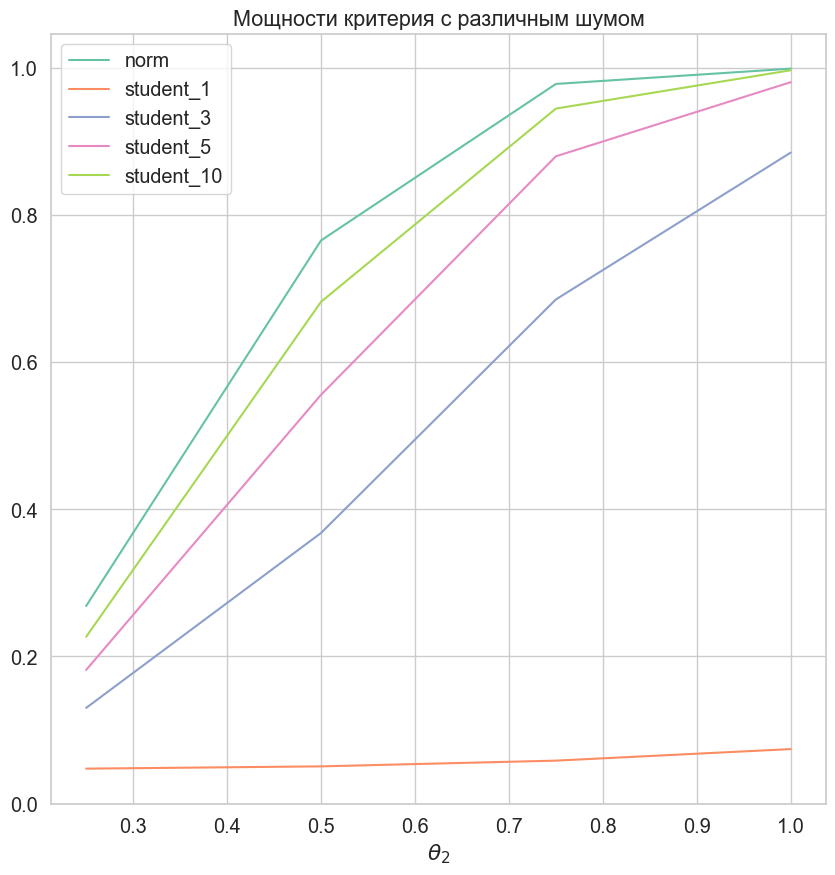

In [36]:
plt.figure(figsize=(10, 10))
for word in results.keys():
    res = np.array(np.split(np.array(results[word]), 10, axis=1)).mean(axis=0).mean(axis=1)
    plt.plot(thetas, res.squeeze(), label=word)
plt.legend()
plt.title('Мощности критерия с различным шумом')
plt.xlabel('$\\theta_2$')
plt.show()

Можем заметить, что чем ближе распределение к нормальному, тем мощнее критерий для каждого значения параметра

**Вывод:**
В случае гомоскедастичности вероятность ошибки первого рода контролируется на заданном уровне значимости, что соответствует теоретическим ожиданиям. Однако в условиях гетероскедастичности возможны отклонения от этого уровня, особенно если дисперсия ошибки систематически связана с параметром, входящим в проверяемую гипотезу. 

Чем ближе распределение ошибки к нормальному, тем выше мощность критерия, что, в свою очередь, может приводить к увеличению вероятности ошибки первого рода, поскольку критерий становится более склонным к отклонению нулевой гипотезы даже в пограничных случаях.
